### Загружаем текст и ищем, по какому символу разбить

In [127]:
with open("data/reviews.txt", "r") as file:
    text = file.read()
    
text = text.lstrip("INTELLIGENCE\n\n")

In [128]:
tokens = text.split()

In [129]:
from collections import Counter
c = Counter(tokens)
c.most_common(25)

[('1.215', 1244),
 ('и', 640),
 ('не', 636),
 ('1.214.1', 484),
 ('в', 432),
 ('сдавать', 430),
 ('кому', 405),
 ('на', 259),
 ('что', 257),
 ('только', 234),
 ('я', 217),
 ('Не', 205),
 ('за', 192),
 ('Дискриминация', 182),
 ('приложение', 179),
 ('квартиру', 176),
 ('а', 164),
 ('хочу', 163),
 ('с', 158),
 ('Я', 146),
 ('для', 145),
 ('это', 144),
 ('славян', 139),
 ('как', 134),
 ('вы', 133)]

Разбиваем

In [130]:
import re
reviews = [x.strip().lower() for x in re.split("1.215|1.214.1", text)]

In [131]:
reviews[:5]

['дискриминация собственников жилья. русофобы!!!',
 'ужас из за убранной возможности указывать национальность, костре приехали и чуть не избили нерусские за то что я им отказал! удаляю навсегда!!!!',
 'я буду сдавать квартиру,кому хочу и это буду славяне!🙋🏼\u200d♂️☀️ приложение ужасное,и проведайте там свои акции компании,как вы играете в толерастов и акции идут в упадок…',
 'спасибо циан! придется разговаривать с людьми, плохо знающими русский язык, которые хотят заселиться всем табуном в мою квартиру. спасибо, вы сами же и усложнили поиск квартиры иностранцам ближнего зарубежья, теперь им придется побегать и потрать кучу времени на поиск человека, которому безразлично на то, кому сдавать квартиру',
 'почему решать кому-то кому я хочу сдавать квартиру? почему решаете вы, что делать с моей собственностью, захочу только собакам сдавать буду, а захочу бригаду строителей, это не правила а бред.']

### Токенизируем: с нормализацией и без

In [132]:
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import numpy as np

In [133]:
import string
from nltk.tokenize import WhitespaceTokenizer, WordPunctTokenizer, TreebankWordTokenizer
from nltk.corpus import stopwords

stop_words = stopwords.words('russian')
stop_words.extend([x for x in string.punctuation] + ["«", "»", "это", "циан", "!!!"])

In [134]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def normalize(x):
    return morph.parse(x)[0].normal_form

def extract_POS(x):
    return morph.parse(x)[0].tag.POS or "None"

In [135]:
tokenized_reviews = []
normalized_reviews = []

for r in reviews:
    tokens = [x for x in WordPunctTokenizer().tokenize(r) if x not in stop_words]
    tokenized_reviews.append(tokens)
    normalized_reviews.append([normalize(x) for x in tokens])

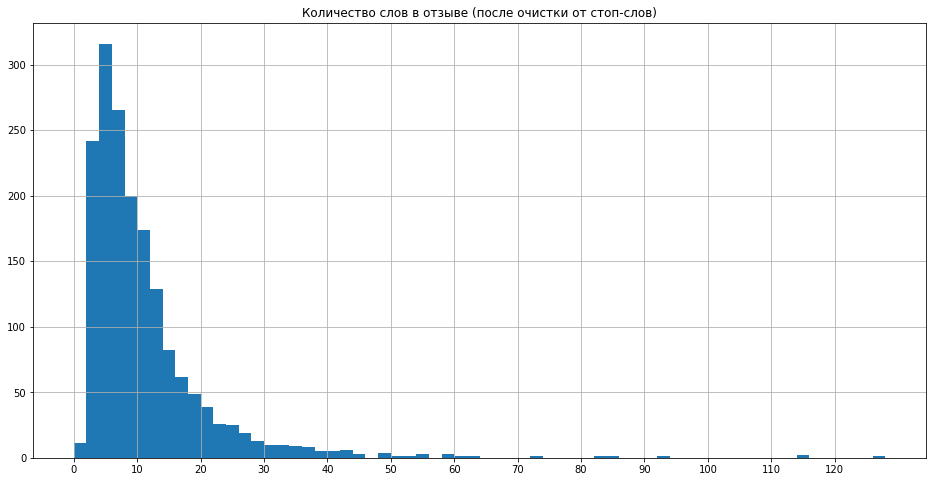

In [136]:
plt.figure(figsize=(16, 8))
plt.hist([len(x) for x in tokenized_reviews], bins=np.arange(0, 130, 2), rwidth=1)
plt.grid()
plt.title("Количество слов в отзыве (после очистки от стоп-слов)")
plt.xticks(np.arange(0, 130, 10))
plt.show()

In [137]:
POS_arr = []
for r in tokenized_reviews:
    POS_arr += [extract_POS(x) for x in r]

In [138]:
pos_counter = Counter(POS_arr)

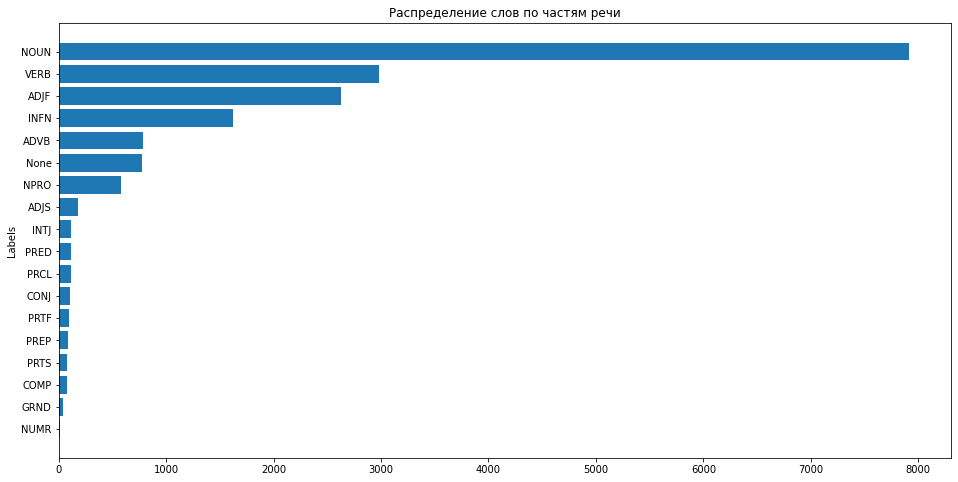

In [139]:
ntop = len(pos_counter)
xs = np.arange(len(pos_counter))
ys = [y for x, y in pos_counter.most_common(ntop)][::-1]
labels = [x for x, y in pos_counter.most_common(ntop)][::-1]

plt.figure(figsize=(16, 8))
plt.title("Распределение слов по частям речи")

plt.barh(xs, ys)
plt.yticks(xs, labels=[x + "" for x in labels])
plt.ylabel("Labels")
plt.show()

Расшифровка тэгов:
https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html#grammeme-docs

### Считаем частоты  n-грамм

In [140]:
def make_n_grams(arr, n, sep=" "):
    return [sep.join(arr[i:i+n]) for i in range(len(arr) - min(len(arr), n) + 1)]

In [141]:
N = 4

In [142]:
n_grams = defaultdict(list)
for tokens in tokenized_reviews:
    for i in range(1, N + 1):
        n_grams[i] += make_n_grams(tokens, i)

In [143]:
counters = {}
for key, value in n_grams.items():
    counters[key] = Counter(value)

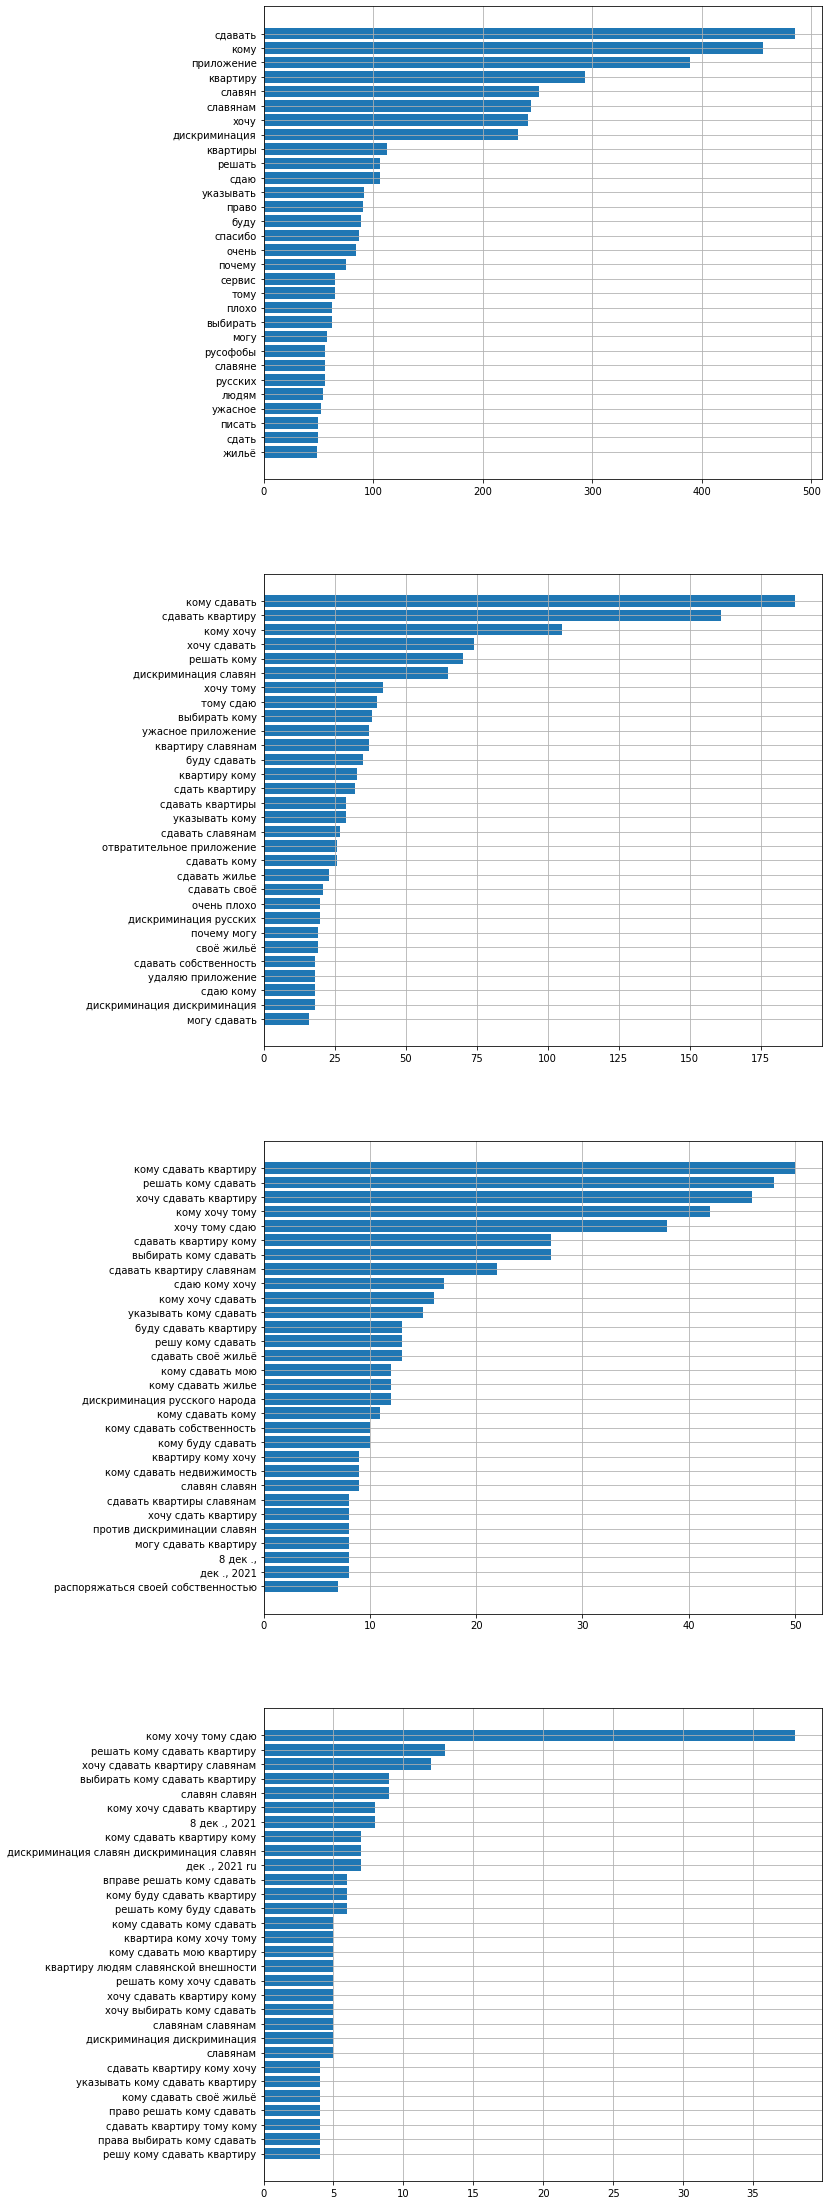

In [144]:
ncols = 1
nrows = math.ceil(N / ncols)
ntop = 30

fig, axs = plt.subplots(figsize=(10 * ncols, 10 * nrows), ncols=ncols, nrows=nrows)

keys = []

for i, key in enumerate(counters.keys()):
    ax = axs.reshape(-1)[i]
    xs = np.arange(ntop)
    ys = [y for x, y in counters[key].most_common(ntop)][::-1]
    labels = [x for x, y in counters[key].most_common(ntop)][::-1]
    ax.grid()
    ax.barh(xs, ys)
    ax.set_yticks(xs)
    ax.set_yticklabels(labels, rotation=0)

plt.show()

### То же самое, но с нормализацией

In [145]:
n_grams = defaultdict(list)
for tokens in normalized_reviews:
    for i in range(1, N + 1):
        n_grams[i] += make_n_grams(tokens, i)

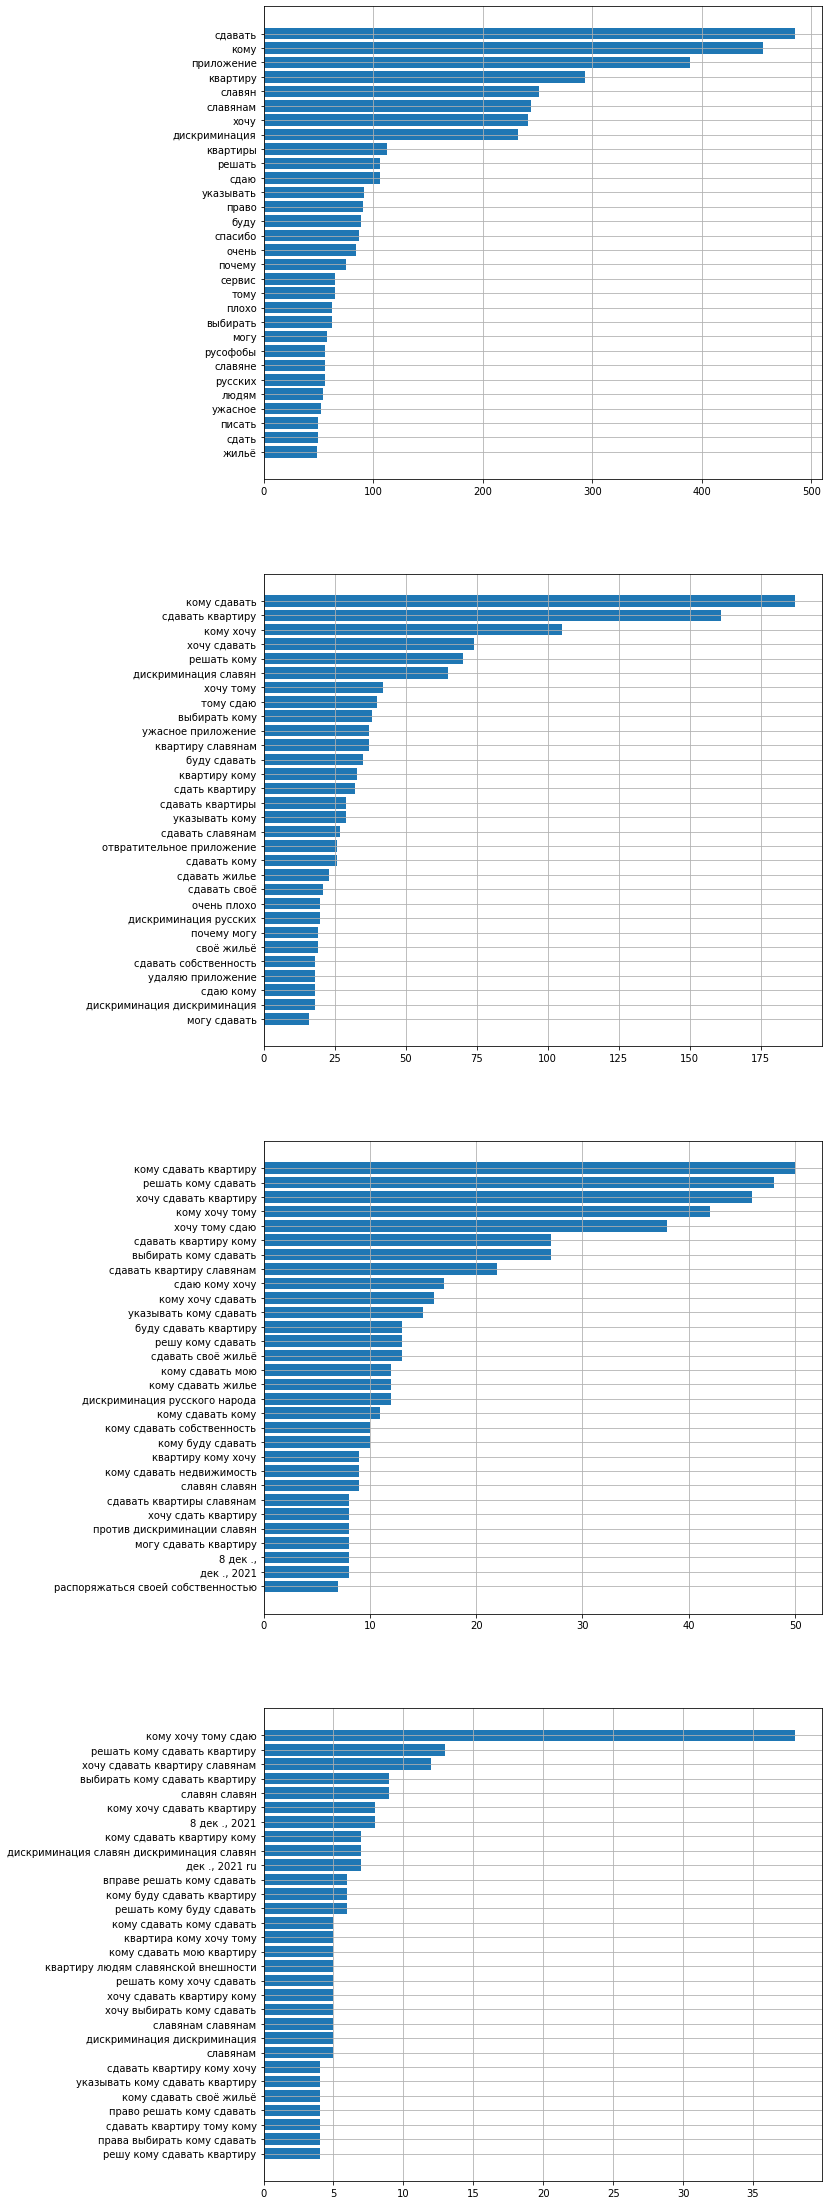

In [146]:
ncols = 1
nrows = math.ceil(N / ncols)
ntop = 30

fig, axs = plt.subplots(figsize=(10 * ncols, 10 * nrows), ncols=ncols, nrows=nrows)

keys = []

for i, key in enumerate(counters.keys()):
    ax = axs.reshape(-1)[i]
    xs = np.arange(ntop)
    ys = [y for x, y in counters[key].most_common(ntop)][::-1]
    labels = [x for x, y in counters[key].most_common(ntop)][::-1]
    ax.grid()
    ax.barh(xs, ys)
    ax.set_yticks(xs)
    ax.set_yticklabels(labels, rotation=0)

plt.show()

## Анализ тональности 
Как в https://habr.com/ru/post/472988/

In [27]:
!pip3 install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 KB 1.5 MB/s eta 0:00:00m eta 0:00:010:00:01


In [28]:
from textblob import TextBlob

In [32]:
sentence = '''The platform provides universal access to the world's best education, partnering with top universities and organizations to offer courses online.'''

analysisPol = TextBlob(sentence).polarity
analysisSub = TextBlob(sentence).subjectivity

analysisPol,analysisSub

(0.5, 0.26666666666666666)

In [33]:
sentence = '''Всё очень плохо я так больше не могу'''

analysisPol = TextBlob(sentence).polarity
analysisSub = TextBlob(sentence).subjectivity

analysisPol,analysisSub

(0.0, 0.0)